In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt 
from PIL import Image 
import time 
from IPython import display

%matplotlib inline 

In [2]:
import utils as utils

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [4]:
tf.config.list_physical_devices('GPU') 

[]

# Prepare Dataset 

In [5]:
BATCH_SIZE = 32 
AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically
SHUFFLE_BUFFER_SIZE = 8    # Shuffle the training data by a chunck of this many observations

In [6]:
filenames = utils.get_filenames_list('data/dataset64-easy-gaus/')
train_ds = utils.create_dataset(filenames, SHUFFLE_BUFFER_SIZE, AUTOTUNE, BATCH_SIZE)

In [7]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

# Model building - attempt 01 

## Architecture 

In [8]:
LATENT_DIM = 10

Model architecture from tf tutorials on MNIST dataset 

In [9]:
encoder = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(64, 64, 1)),
        tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
        tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
        tf.keras.layers.Flatten(),
        # No activation
        tf.keras.layers.Dense(LATENT_DIM + LATENT_DIM) 
        ])


In [10]:
decoder = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(LATENT_DIM,)),
        tf.keras.layers.Dense(units=8*8*32, activation=tf.nn.relu),
        tf.keras.layers.Reshape(target_shape=(8, 8, 32)),
        tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=4, padding='same',
            activation='relu'),
        tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same',
            activation='relu'),
        # No activation
        tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same'),
        ])


In [11]:
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2048)              22528     
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 64, 64, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 64, 64, 1)         289       
Total params: 59,777
Trainable params: 59,777
Non-trainable params: 0
_________________________________________________________________


Utilities for VAE 

In [12]:
@tf.function
def sample(epsilon=None):
    """ Forward pass through second half of network.  Used for generating data samples.    
        Sample epsilon using tensorflow utilities 
    """
    if epsilon is None:
        epsilon = tf.random.normal(shape=(100, LATENT_DIM))
    return decode(epsilon, apply_sigmoid=True)



def encode(X): 
    """ Forward pass of encoder network 
    
        Input is data vector, X.  
    """
    mean, logvar = tf.split(encoder(X), num_or_size_splits=2, axis=1)
    return mean, logvar 


def reparameterize(mean, logvar):
    """ Forward pass through bottleneck section of network.  Outputs z vector.  
    """
    epsilon = tf.random.normal(shape=mean.shape)
    return epsilon * tf.exp(logvar * .5) + mean




def decode(z, apply_sigmoid=False): 
    """ Forward pass of decoder network.  
    
        Input is a sampled z vector 
    """
    logits = decoder(z) 
    
    if apply_sigmoid: 
        probs = tf.sigmoid(logits)
        return probs 
    return logits 
    

# Optimizer and loss 

In [13]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
    """ Utility for ELBO.
    """
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(x, y): 
    """ Calculates model loss 
    """
    # Forward pass through the network 
    mean, logvar = encode(x)
    z = reparameterize(mean, logvar)
    x_logit = decode(z)
    
    # Calculate reconstruction loss (binary cross entropy)
    # Reconstruction loss will evaluate the similarity between inp and out. 
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=y)
    
    # Calculate regularization portion (ELBO) 
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)
    

Training functions 

In [14]:
@tf.function
def train_step(x, y, optimizer):
    """Executes one training step and returns the loss.  

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    
    # Use GradientTape to record a computation graph 
    with tf.GradientTape() as tape:
        loss = compute_loss(x, y)
        
    # The tape is used to compute gradients using the computation graph 
    trainable_vars = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)
    optimizer.apply_gradients(zip(gradients, trainable_vars))
    
    return loss 


# Utilities for image generation


In [15]:
num_examples_to_generate = 16
batch_size=32 

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, LATENT_DIM])

In [16]:
def generate_and_save_images(epoch, test_sample):
    """ Utility for saving image during training epoch   
    """
    mean, logvar = encode(test_sample)
    z = reparameterize(mean, logvar)
    # Use the sample function to generate a new sample z vector 
    predictions = sample(z)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()


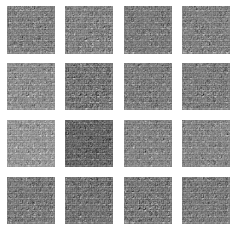

In [17]:
# Set aside a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate

for test_batch in train_ds.take(1):
    test_sample = test_batch[0][0:num_examples_to_generate, :, :, :]
generate_and_save_images(0, test_sample)

## Trainin' 

In [18]:
epochs = 100
num_examples_to_generate = 16

In [19]:
losses = []

Epoch: 32, time elapse for current epoch: 4.908487558364868


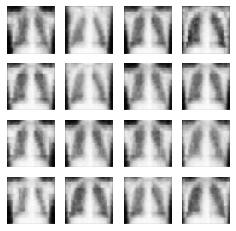

In [ ]:
for epoch in range(1, epochs + 1):
    
    # tic
    start_time = time.time()
    
    for train_x, train_y in train_ds: 
        l = train_step(train_x, train_y, optimizer)
        losses.append(l)

    print("Epoch {}.  Loss: {}".format(epoch, l))
    
    # toc 
    end_time = time.time()

    display.clear_output(wait=False)
    print('Epoch: {}, time elapse for current epoch: {}'
        .format(epoch, end_time - start_time))
    generate_and_save_images(epoch, test_sample)

In [ ]:
plt.plot(np.arange(len(losses)), losses)

+ [x] training loop appears to work
+ [ ] build the random number seed thing in 

## Save generated as GIF 

In [ ]:
import imageio, glob

anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

# Testing 
Take and image, pass through network.

In [ ]:
for i in train_ds.take(1): 
    ims = i[0]
    
    
fig, ax = plt.subplots(4, 4, figsize=(6, 6))
ax = ax.reshape(-1) 

for i, ax in enumerate(ax): 
    ax.imshow(np.squeeze(ims[i]))
    ax.axis(False)

## Pass through network 

In [ ]:
mean, logvar = encode(ims)
z = reparameterize(mean, logvar)
x_logit = decode(z)

In [ ]:
fig, ax = plt.subplots(4, 4, figsize=(6, 6))
ax = ax.reshape(-1)

for i, ax in enumerate(ax):
    ax.imshow(np.squeeze(x_logit[i]))
    ax.axis(False)

## SAve model 


In [ ]:
from datetime import datetime
import os

now = datetime.now().date()
os.makedirs('saved_model/' + str(now) + '/encoder/')
os.makedirs('saved_model/' + str(now) + '/decoder/')


In [ ]:
encoder.save('saved_model/' + str(now) + '/encoder')
decoder.save('saved_model/' + str(now) + '/decoder')

In [ ]:
losses_lst = [l.numpy() for l in losses]

In [ ]:
with open('saved_model/' + str(now) + '/losses.txt', 'w') as f:
    for item in losses_lst:
        f.write("%s\n" % item)

# TODO 
+ Research autoencoder architecture and loss functions that could help with overblurring 